In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import glob

In [ ]:
def load_df(filename):
    cols_to_remove = [
        "done", "training_iteration", "trial_id", "date",
        "timestamp", "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore",
    ]
    return pd.read_csv(filename).drop(columns=cols_to_remove)

def calculate_stats(df):
    # first filter df to filter out the 9e99 numbers
    # count, mean, median, mode, range, variance, standard deviation
    stats = {}
    df = df[df['minimum'] != 9e99]
    stats['count'] = df['minimum'].count()
    stats['qor_mean'] = df['minimum'].mean()
    stats['qor_median'] = df['minimum'].median()
    stats['qor_range'] = df['minimum'].max() - df['minimum'].min()
    stats['qor_variance'] = df['minimum'].var()
    stats['qor_std'] = df['minimum'].std()
    stats['qor_q1'] = df['minimum'].quantile(0.25)
    stats['time_this_iter_s_mean'] = df['time_this_iter_s'].mean()
    stats['time_this_iter_s_median'] = df['time_this_iter_s'].median()
    stats['time_this_iter_s_range'] = df['time_this_iter_s'].max() - df['time_this_iter_s'].min()
    stats['time_this_iter_s_variance'] = df['time_this_iter_s'].var()
    stats['time_this_iter_s_std'] = df['time_this_iter_s'].std()
    stats['time_this_iter_s_q1'] = df['time_this_iter_s'].quantile(0.25)
    return stats, df

def plot(df_list, title):
    # Plot boxplot for all df, side by side with labels
    fig, ax = plt.subplots(2, figsize=(10, 10))
    for i, df in enumerate(df_list):
        ax[0].boxplot(df['minimum'], positions=[i], widths=0.6)
        ax[0].set_xticks([0, 1, 2])
        ax[0].set_xticklabels(['2.7', '2.8', '2.9'])
        ax[0].set_title('Minimum')
        ax[1].boxplot(df['time_this_iter_s'], positions=[i], widths=0.6)
        ax[1].set_xticks([0, 1, 2])
        ax[1].set_xticklabels(['2.7', '2.8', '2.9'])
        ax[1].set_title('Time this iter')

        # Set overall title
        fig.suptitle(title)
df_list = []

# Generate all the plots for the following matrix:
DATE = "20240730"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        df_list = []
        q1_list = {}
        # plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            df = load_df(filename)
            stats, df = calculate_stats(df)
            print(f"Stats for {filename}")
            print(stats)
            df_list.append(df)
            q1_list[ray_version] = stats['qor_q1']
        # plot(df_list, f"{design} {platform}")
        print("-------------------")
        print(f"Q1 for {design} {platform} {q1_list}")
        print(f"Maximum Q1 value: {max(q1_list.values())}")
        print("-------------------")
        

In [ ]:
# Update: 20240809
DATE="20240809"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        df_list = []
        q1_list = {}
        # plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            df = load_df(filename)
            stats, df = calculate_stats(df)
            print(f"Stats for {filename}")
            print(stats)
            df_list.append(df)
            q1_list[ray_version] = stats['qor_q1']
        # plot(df_list, f"{design} {platform}")
        print("-------------------")
        print(f"Q1 for {design} {platform} {q1_list}")
        print(f"Maximum Q1 value: {max(q1_list.values())}")
        print("-------------------")

# Analysis of improvement over time
- QoR
- FMax (WNS, Clk period)


In [ ]:
def preprocess(filename):
    cols_to_remove = [
        "done", "training_iteration", "trial_id", "date",
        "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore",
    ]
    df = pd.read_csv(filename).drop(columns=cols_to_remove)
    df['timestamp'] = df['timestamp'] - df['timestamp'].min()
    return df[df['minimum'] != 9e99]

def plot_qor(df, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = df['timestamp'], df['minimum']
    ax.scatter(x, y)
    ax.set_title('QoR versus time')
    ax.set_xlabel('Time/s')
    ax.set_ylabel('QoR')
    ax.grid()
    ax.set_title(title)

    # Plot a linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.2, label=f"y={z[0]:.2f}x + {z[1]:.2f}")
    ax.legend()

# Generate all the plots for the following matrix:
DATE = "20240730"
# DATE="20240809"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        plt.figure()
        for ray_version in ['ray27', 'ray28', 'ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            df = preprocess(filename)
            plot_qor(df, f"{ray_version} {design} {platform}")


20240730/ray29-gcd-asap7.csv
20240730/ray29-aes-asap7.csv


20240730/ray29-ibex-asap7.csv


<Figure size 640x480 with 0 Axes>

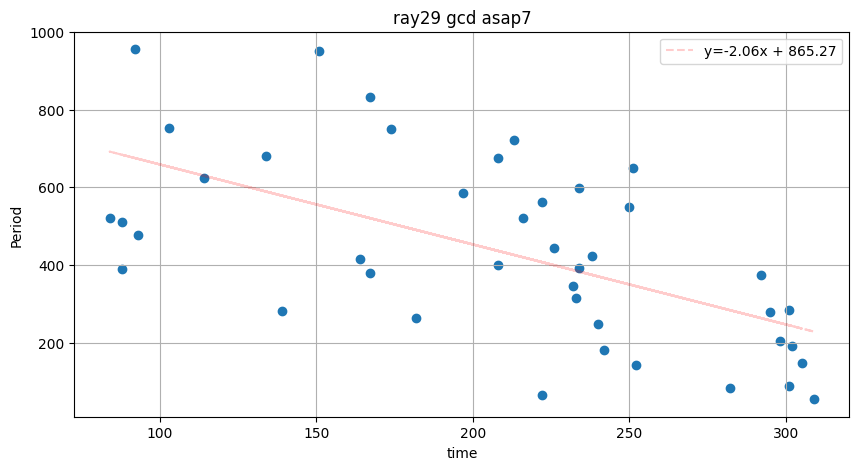

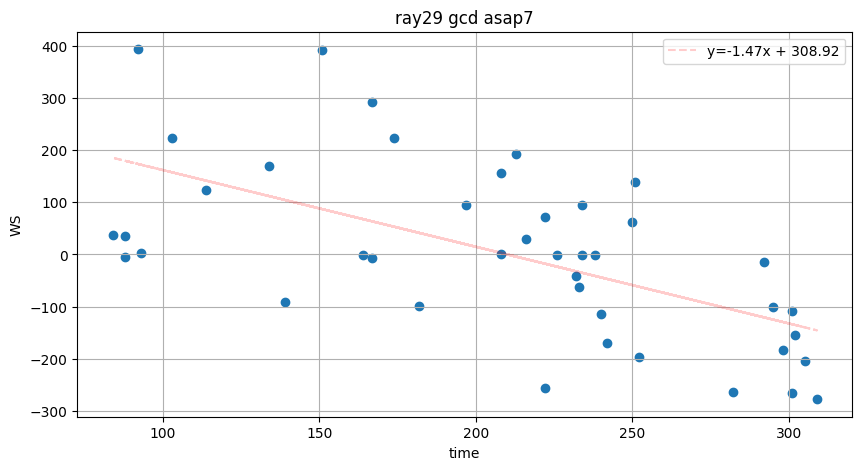

<Figure size 640x480 with 0 Axes>

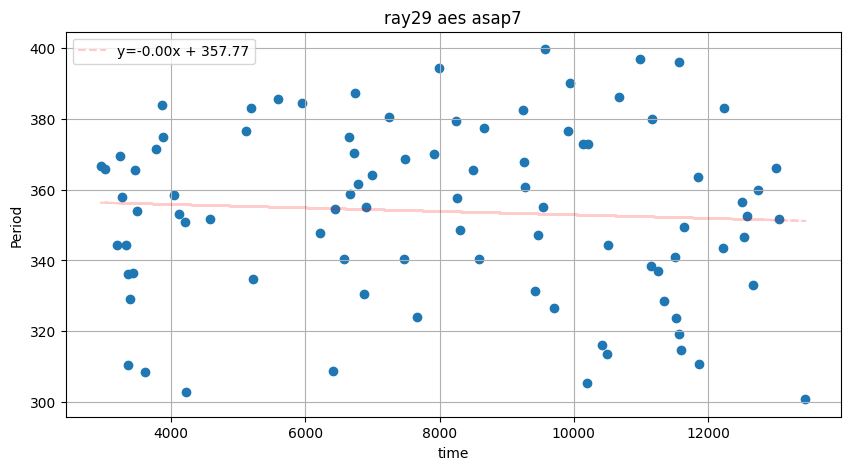

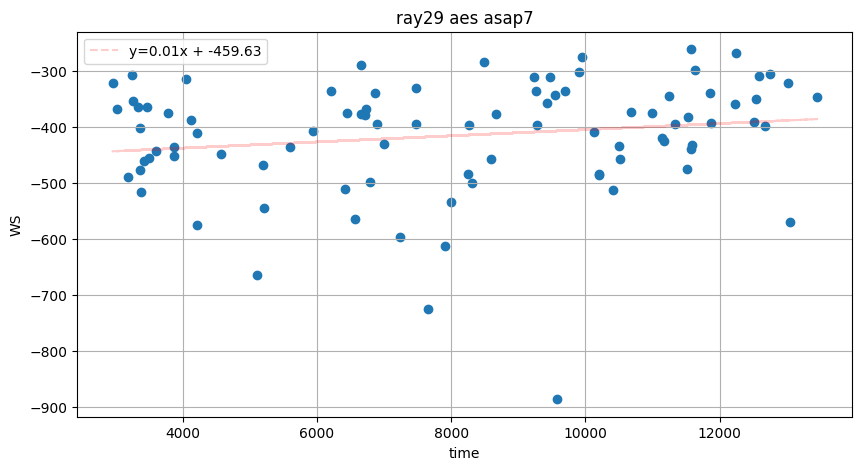

<Figure size 640x480 with 0 Axes>

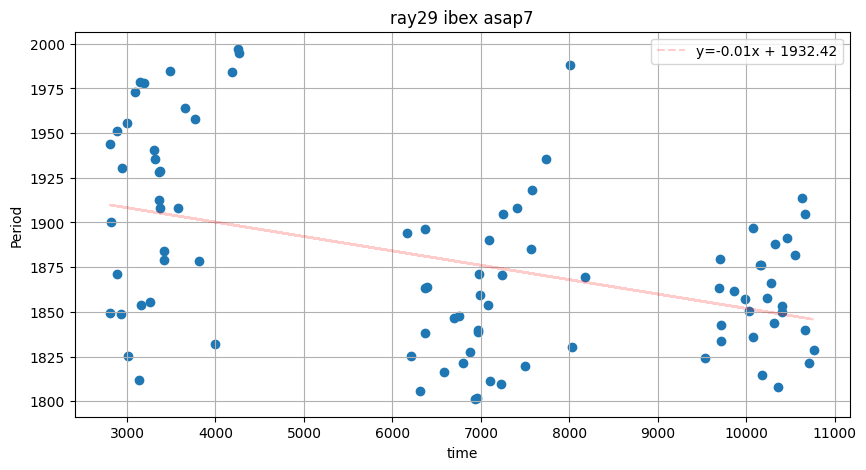

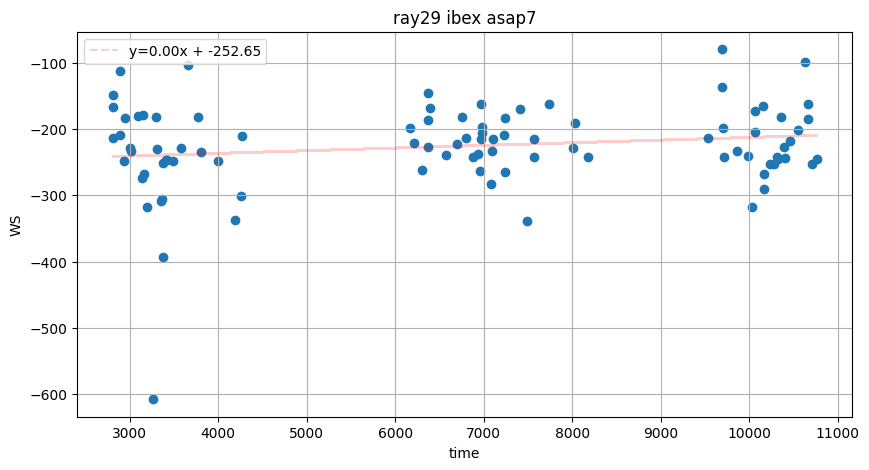

In [70]:
def preprocess_fmax(filename):
    platform, design = filename.split('-')[-1].replace('.csv', ''), filename.split('-')[-2]
    cols_to_remove = [
        "done", "training_iteration", "date",
        "pid", "hostname", "node_ip", "time_since_restore",
        "time_total_s", "iterations_since_restore",
    ]
    df = pd.read_csv(filename).drop(columns=cols_to_remove)
    df['timestamp'] = df['timestamp'] - df['timestamp'].min()
    df = df[df['minimum'] != 9e99]

    # filter df where trial_id length is 8
    df = df[df['trial_id'].apply(lambda x: len(x) == 8)]

    # filter folders that have the trial_ids
    ws_list, period_list = [], []
    for trial_id in df['trial_id']:
        path = glob.glob(f"../../../../../flow/logs/{platform}/{design}/*/*{trial_id}-ray")[0]
        expt = json.load(open(f"{path}/metrics.json"))
        ws_list.append(float(expt['finish']['timing__setup__ws']))
        period_list.append(float(expt['constraints']['clocks__details'][0].replace('core_clock: ', '').replace('clk: ', '')))
    assert len(ws_list) == len(period_list), "Length mismatch"
    return df, ws_list, period_list

def plot_fmax(df, period_list, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = df.timestamp, period_list
    ax.scatter(x, y)
    ax.set_xlabel('time')
    ax.set_ylabel('Period')
    ax.grid()
    ax.set_title(title)

    # Plot a linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.2, label=f"y={z[0]:.2f}x + {z[1]:.2f}")
    ax.legend()

def plot_ws(df, ws_list, title):
    fig, ax = plt.subplots(figsize=(10, 5))
    x, y = df.timestamp, ws_list
    ax.scatter(x, y)
    ax.set_xlabel('time')
    ax.set_ylabel('WS')
    ax.grid()
    ax.set_title(title)

    # Plot a linear fit
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--", alpha=0.2, label=f"y={z[0]:.2f}x + {z[1]:.2f}")
    ax.legend()


DATE = "20240730"
# DATE="20240809"
for design in ['gcd', 'aes', 'ibex']:
    for platform in ['asap7', 'sky130hd', 'ihp-sg13g2']:
        plt.figure()
        for ray_version in ['ray29']:
            filename = f"{DATE}/{ray_version}-{design}-{platform}.csv"
            print(filename)
            df, ws, period = preprocess_fmax(filename)
            plot_fmax(df, period, f"{ray_version} {design} {platform}")
            plot_ws(df, ws, f"{ray_version} {design} {platform}")
            break
        break
